In [1]:
import numpy as np
import time
import cvxpy as cp
from copy import deepcopy
from typing import NamedTuple, List
from simulation_parameters import SimulationConfiguration, SimulationGeneralParameters, \
    EnvType, SimulationParameters, EnvParameters
from multireward_ope.tabular.envs.env import make_env, EnvParameters, EnvType, RiverSwimParameters
from multireward_ope.tabular.agents.make_agent import make_agent, \
    NoisyPolicyParameters, MRNaSPEParameters, AgentParameters, PolicyNoiseType
from multireward_ope.tabular.agents.base_agent import Experience
from multireward_ope.tabular.reward_set import RewardSet, RewardSetCircle, \
    RewardSetRewardFree
from multireward_ope.tabular.policy import Policy, PolicyFactory
from multireward_ope.tabular.utils import policy_evaluation
seed = 0 
discount_factor = 0.9
HORIZON = 20000
NUM_REWARDS = 30
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
np.random.seed(seed)

env_params = EnvParameters(
    env_type=EnvType.RIVERSWIM,
    parameters=RiverSwimParameters(num_states=10))

env = make_env(env = env_params)

reward_set = RewardSetCircle(env.dim_state, env.dim_action, 
        RewardSetCircle.RewardSetCircleConfig(np.zeros(env.dim_state), radius=1, p=2))
reward_set = RewardSetRewardFree(env.dim_state, env.dim_action, 
        RewardSetRewardFree.RewardSetFreeConfig())




In [2]:

agent_params = AgentParameters(
        dim_state_space=env.dim_state,
        dim_action_space=env.dim_action,
        discount_factor=discount_factor,
        horizon=HORIZON,
        frequency_evaluation=250,
        delta=1e-2,
        epsilon=0.1,
        solver_type=cp.GUROBI)

results = {}

agents = [
NoisyPolicyParameters(
            agent_parameters=agent_params,
            noise_type=PolicyNoiseType.VISITATION,
            noise_parameter=0.3
        ),
NoisyPolicyParameters(
            agent_parameters=agent_params,
            noise_type=PolicyNoiseType.UNIFORM,
            noise_parameter=0.3
        ),
# MRNaSPEParameters(
#             agent_parameters=agent_params,
#             period_computation_omega=500,
#             alpha=.95,
#             beta=.05,
#             averaged=True,
#             avg_transition=True
#         ),
# MRNaSPEParameters(
#             agent_parameters=agent_params,
#             period_computation_omega=500,
#             alpha=.95,
#             beta=.05,
#             averaged=True,
#             avg_transition=False
#         ),
MRNaSPEParameters(
            agent_parameters=agent_params,
            period_computation_omega=500,
            alpha=0.95,
            beta=0.05,
            averaged=False,
            avg_transition=True
        ),
    MRNaSPEParameters(
            agent_parameters=agent_params,
            period_computation_omega=500,
            alpha=1-1e-5,
            beta=1e-5,
            averaged=False,
            avg_transition=False
        ),
]
for id_sim in range(10):
    policy_to_eval = PolicyFactory.random(env.dim_state, env.dim_action)

    eval_rewards = reward_set.sample(NUM_REWARDS)
    rewards = np.zeros((NUM_REWARDS, env.dim_state, env.dim_action))
    values = np.zeros((NUM_REWARDS, env.dim_state))
    for i in range(NUM_REWARDS):
        rewards[i, np.arange(env.dim_state), policy_to_eval] = eval_rewards[i]

        values[i] = env.policy_evaluation(rewards[i], discount_factor, policy_to_eval)
    for params in agents:
        agent = make_agent(params,
            policy=policy_to_eval,
            reward_set=reward_set)
        
        if agent.name not in results:
            results[agent.name] = []


        start_time = time.time()
        s = env.reset()
        res = []

        for t in range(HORIZON):
            a = agent.forward(s, t)
            next_state, _ = env.step(a)
            exp = Experience(s, a, next_state)
            reset = agent.backward(exp, t)

            s = env.reset() if reset else next_state

            # Evaluate the agent
            if (t +1) % agent_params.frequency_evaluation == 0:
                hat_values = np.array([
                    policy_evaluation(discount_factor, agent.empirical_transition(), R=rewards[r], policy=policy_to_eval)
                    for r in range(NUM_REWARDS)])

                err = np.linalg.norm(values - hat_values, ord=np.inf, axis=-1)
                #  {agent.state_action_visits}
                print(f'[{t}]  {agent.U_t} {agent.Z_t} - {agent.beta} - {err.mean()} - {err.std()}')
                print('--------')
                res.append((err.mean(), err.std()))
                
        results[agent.name].append(res)
        #         # Append results to be saved
        #         results.append(
        #                 Results(step=t, omega=deepcopy(agent.omega), total_state_visits=deepcopy(agent.total_state_visits),
        #                         last_visit= deepcopy(agent.last_visit), exp_visits=deepcopy(agent.exp_visits), V_res=V_res,
        #                         Q_res=Q_res, pi_res=pi_res, elapsed_time=time.time() - start_time))
        # return results

Restricted license - for non-production use only - expires 2026-11-23
[249]  17966.08618729563 0.013915106350585285 - 277.4757059418799 - 1.9766767892363417 - 1.0244183899068773
--------
[499]  25933.260365959988 0.01928025990346745 - 315.3918055959853 - 1.9871479710935351 - 1.113845348220219
--------
[749]  31846.894584915954 0.023550176862620443 - 340.8843750267827 - 1.9778192523879825 - 1.1429137354745116
--------
[999]  36884.178742477285 0.027111895508964128 - 364.82595377499445 - 1.964762123559375 - 1.1591711748730698
--------
[1249]  42757.7231069511 0.029234484653762775 - 378.4089210060084 - 1.9651607776424416 - 1.174815929916345
--------
[1499]  46804.37315494191 0.03204828734773089 - 388.21629567289546 - 1.9590939638878295 - 1.185959684990137
--------


c:\Users\russo\github\multi-reward-ope\.venv\Lib\site-packages\cvxpy\problems\problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


[1749]  50049.634895998846 0.03496529002931651 - 396.09328972136944 - 1.9572822056514998 - 1.1956736319306862
--------
[1999]  51567.6250369977 0.03878402386313274 - 401.94341386370905 - 1.9658320874702677 - 1.1986607788224934
--------
[2249]  52830.18304976881 0.04258929025251307 - 407.52036642019397 - 1.9728973481884462 - 1.2034315320408004
--------
[2499]  56363.12812888821 0.0443552386638856 - 412.9148394210693 - 1.9648539400251268 - 1.2110864990367427
--------
[2749]  58100.52307610246 0.04733175975710127 - 421.0100525590134 - 1.9546828107759076 - 1.2213482385080892
--------
[2999]  58738.694750416136 0.05107365787999139 - 427.17235616341225 - 1.9490184802719077 - 1.2237967463095885
--------
[3249]  60324.28623285007 0.05387548204806088 - 433.32159633904257 - 1.9435870060499145 - 1.2249380902256795
--------
[3499]  61880.87700011125 0.056560284366908825 - 439.78512363039965 - 1.939245973599936 - 1.2280939443371568
--------
[3749]  63334.44981605918 0.05920948253108759 - 448.491046

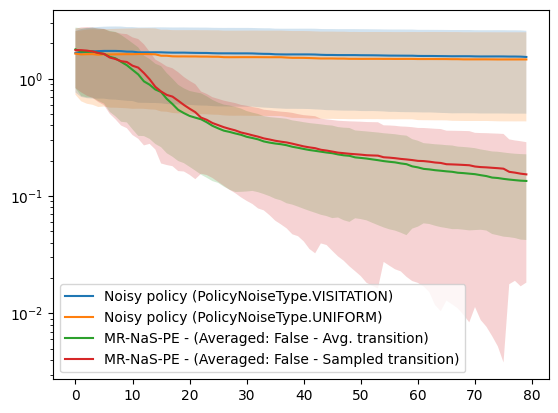

In [10]:
import matplotlib.pyplot as plt

for agent_name in results:
    data = np.array(results[agent_name])
    mu = data[:,:,0].mean(0)
    var = data[:,:,1] ** 2
    std = np.sqrt(var.mean(0) + data[:,:,0].var(0))
    plt.plot(data[:,:,0].mean(0), label=str(agent_name))
    plt.fill_between(range(80), mu-std, mu+std, alpha=0.2 )
    plt.yscale('log')
    plt.legend()

In [4]:
mu

array([1.751, 1.750, 1.735, 1.707, 1.657, 1.626, 1.516, 1.471, 1.410,
       1.388, 1.290, 1.243, 1.117, 0.987, 0.852, 0.778, 0.727, 0.703,
       0.649, 0.598, 0.555, 0.518, 0.466, 0.446, 0.419, 0.402, 0.386,
       0.373, 0.363, 0.348, 0.339, 0.329, 0.321, 0.310, 0.303, 0.296,
       0.291, 0.286, 0.279, 0.272, 0.265, 0.260, 0.256, 0.248, 0.244,
       0.239, 0.234, 0.232, 0.229, 0.227, 0.225, 0.223, 0.222, 0.221,
       0.214, 0.212, 0.210, 0.207, 0.205, 0.202, 0.199, 0.198, 0.196,
       0.193, 0.191, 0.187, 0.186, 0.185, 0.184, 0.183, 0.178, 0.176,
       0.175, 0.174, 0.173, 0.171, 0.161, 0.158, 0.155, 0.153])